In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

In [35]:
df = pd.read_csv('./Data/Hotel_Reservations.csv')

In [36]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [38]:
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [39]:
#Concatenated arrival date, month, and year to create a datetime
df['arrival_date'] = df['arrival_year'].astype(str) + '-' + df['arrival_month'].astype(str) + '-' + df['arrival_date'].astype(str)
df.loc[:, 'arrival_date'] = pd.to_datetime(df['arrival_date'], format='%Y-%m-%d', errors='coerce')
#Dropped incorrect dates (2/29)
df = df.dropna(subset=['arrival_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36238 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Booking_ID                            36238 non-null  object        
 1   no_of_adults                          36238 non-null  int64         
 2   no_of_children                        36238 non-null  int64         
 3   no_of_weekend_nights                  36238 non-null  int64         
 4   no_of_week_nights                     36238 non-null  int64         
 5   type_of_meal_plan                     36238 non-null  object        
 6   required_car_parking_space            36238 non-null  int64         
 7   room_type_reserved                    36238 non-null  object        
 8   lead_time                             36238 non-null  int64         
 9   arrival_year                          36238 non-null  int64         
 10

In [40]:
#Used the lead time metric and arrival date to calculate booking date
df['timedelta'] = pd.to_timedelta(df['lead_time'], unit='D')
df['booking_date'] = df['arrival_date'] - df['timedelta']
df = df.drop(columns=['timedelta'])
#Parsed out booking date into day, month, and year
df['booking_year'] = df['booking_date'].dt.year
df['booking_month'] = df['booking_date'].dt.month
df['booking_day'] = df['booking_date'].dt.day
#Returned arrival day to integer
df['arrival_day'] = df['arrival_date'].dt.day
df.drop(columns=['arrival_date', 'booking_date'], axis = 1, inplace = True)
#Calculated total guest count
df['total_guests'] = df['no_of_adults'] + df['no_of_children']
#Calculated total length of stay
df['length_of_stay'] = df['no_of_weekend_nights'] + df['no_of_week_nights']

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36238 entries, 0 to 36274
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36238 non-null  object 
 1   no_of_adults                          36238 non-null  int64  
 2   no_of_children                        36238 non-null  int64  
 3   no_of_weekend_nights                  36238 non-null  int64  
 4   no_of_week_nights                     36238 non-null  int64  
 5   type_of_meal_plan                     36238 non-null  object 
 6   required_car_parking_space            36238 non-null  int64  
 7   room_type_reserved                    36238 non-null  object 
 8   lead_time                             36238 non-null  int64  
 9   arrival_year                          36238 non-null  int64  
 10  arrival_month                         36238 non-null  int64  
 11  market_segment_

In [42]:
#Re-ordered columns for clarity
reordered = ['booking_status', 'total_guests', 'no_of_adults', 'no_of_children', 'length_of_stay', 'no_of_week_nights', 'no_of_weekend_nights', 'booking_year', 'booking_month', 'booking_day', 'arrival_year', 'arrival_month', 'arrival_day', 'lead_time', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'room_type_reserved', 'avg_price_per_room', 'type_of_meal_plan', 'required_car_parking_space', 'market_segment_type', 'no_of_special_requests']
df = df[reordered]
df.head()

,booking_status,total_guests,no_of_adults,no_of_children,length_of_stay,no_of_week_nights,no_of_weekend_nights,booking_year,booking_month,booking_day,...,lead_time,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,room_type_reserved,avg_price_per_room,type_of_meal_plan,required_car_parking_space,market_segment_type,no_of_special_requests
0,Not_Canceled,2,2,0,3,2,1,2017,2,20,...,224,0,0,0,Room_Type 1,65.00,Meal Plan 1,0,Offline,0
1,Not_Canceled,2,2,0,5,3,2,2018,11,1,...,5,0,0,0,Room_Type 1,106.68,Not Selected,0,Online,1
2,Canceled,1,1,0,3,1,2,2018,2,27,...,1,0,0,0,Room_Type 1,60.00,Meal Plan 1,0,Online,0
3,Canceled,2,2,0,2,2,0,2017,10,21,...,211,0,0,0,Room_Type 1,100.00,Meal Plan 1,0,Online,0
4,Canceled,2,2,0,2,1,1,2018,2,22,...,48,0,0,0,Room_Type 1,94.50,Not Selected,0,Online,0


In [46]:
#Manually encoded categorical variables to have numerical values
df.loc[:, 'type_of_meal_plan'] = df['type_of_meal_plan'].replace({'Not Selected': 0, 'Meal Plan 1': 1, 'Meal Plan 2': 2, 'Meal Plan 3': 3})
df.loc[:, 'room_type_reserved'] = df['room_type_reserved'].replace({'Room_Type 1': 1, 'Room_Type 2': 2, 'Room_Type 3': 3, 'Room_Type 4': 4, 'Room_Type 5': 5, 'Room_Type 6': 6, 'Room_Type 7': 7})
df.loc[:, 'market_segment_type'] = df['market_segment_type'].replace({'Online': 0, 'Offline': 1, 'Corporate': 2, 'Complementary': 2, 'Aviation': 2})
df.loc[:, 'booking_status'] = df['booking_status'].replace({'Not_Canceled': 0, 'Canceled': 1})

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36238 entries, 0 to 36274
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   booking_status                        36238 non-null  int64  
 1   total_guests                          36238 non-null  int64  
 2   no_of_adults                          36238 non-null  int64  
 3   no_of_children                        36238 non-null  int64  
 4   length_of_stay                        36238 non-null  int64  
 5   no_of_week_nights                     36238 non-null  int64  
 6   no_of_weekend_nights                  36238 non-null  int64  
 7   booking_year                          36238 non-null  int64  
 8   booking_month                         36238 non-null  int64  
 9   booking_day                           36238 non-null  int64  
 10  arrival_year                          36238 non-null  int64  
 11  arrival_month  

In [48]:
correlation = abs(df.corrwith(df['booking_status']))
correlation = correlation.sort_values(ascending = False)
correlation

booking_status                          1.000000
lead_time                               0.438629
no_of_special_requests                  0.253339
arrival_year                            0.179762
avg_price_per_room                      0.142721
market_segment_type                     0.136291
booking_month                           0.134092
repeated_guest                          0.107490
length_of_stay                          0.103474
no_of_week_nights                       0.092904
total_guests                            0.089598
no_of_adults                            0.086671
required_car_parking_space              0.086053
no_of_weekend_nights                    0.061704
no_of_previous_bookings_not_canceled    0.060046
type_of_meal_plan                       0.049641
booking_day                             0.047622
no_of_previous_cancellations            0.033871
no_of_children                          0.033033
room_type_reserved                      0.023313
arrival_month       

In [98]:
#Using all columns
X = df.drop(columns = 'booking_status', axis = 1)
y = df['booking_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 100)

#One-hot-encoded categorical features
ohe = OneHotEncoder(drop="first", sparse=False)
X_train_nominal = X_train[['booking_year', 'booking_month', 'booking_day', 'arrival_year', 'arrival_month', 'arrival_day', 'type_of_meal_plan', 'market_segment_type', 'required_car_parking_space', 'repeated_guest', 'room_type_reserved']]
X_test_nominal = X_test[['booking_year', 'booking_month', 'booking_day', 'arrival_year', 'arrival_month', 'arrival_day', 'type_of_meal_plan', 'market_segment_type', 'required_car_parking_space', 'repeated_guest', 'room_type_reserved']]
X_train_nominal_encoded = pd.DataFrame(ohe.fit_transform(X_train_nominal))
X_test_nominal_encoded = pd.DataFrame(ohe.transform(X_test_nominal))

#Scaled numerical features using StandardScaler
scaler = StandardScaler()
X_train_num = X_train[['total_guests', 'no_of_adults', 'no_of_children', 'length_of_stay', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'avg_price_per_room', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests']]
X_test_num = X_test[['total_guests', 'no_of_adults', 'no_of_children', 'length_of_stay', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'avg_price_per_room', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests']]
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num))
X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num))

#Concatenated encoded categorical and scaled numerical dataframes back into a full dataframe of encoded/scaled independent variables
X_train = pd.concat([X_train_nominal_encoded, X_train_num_scaled], axis = 1)
X_test = pd.concat([X_test_nominal_encoded, X_test_num_scaled], axis = 1)

#Used a Logistic Regression model and calculated AUC, recall, precision, accuracy, and F1
logreg = LogisticRegression(fit_intercept = False, max_iter = 1000, C = 1e5, random_state = 100, solver = 'liblinear')
y_score_log = logreg.fit(X_train, np.ravel(y_train)).decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score_log)
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

#Printed results
print(f"AUC: {auc(fpr, tpr)}")
print(f"Train Recall: {recall_score(y_train, y_hat_train)}")
print(f"Test Recall: {recall_score(y_test, y_hat_test)}")
print(f"Train Precision: {precision_score(y_train, y_hat_train)}")
print(f"Test Precision: {precision_score(y_test, y_hat_test)}")
print(f"Train Accuracy: {accuracy_score(y_train, y_hat_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_hat_test)}")
print(f"Train F1 Score: {f1_score(y_train, y_hat_train)}")
print(f"Test F1 Score: {f1_score(y_test, y_hat_test)}")

AUC: 0.8753529103119388
Train Recall: 0.6474142097631707
Test Recall: 0.6213214880621877
Train Precision: 0.7478018143754361
Test Precision: 0.7550607287449392
Train Accuracy: 0.8137270361901758
Test Accuracy: 0.8077630610743194
Train F1 Score: 0.6939965028171751
Test F1 Score: 0.6816935729515687


AUC: 0.8753536740630873


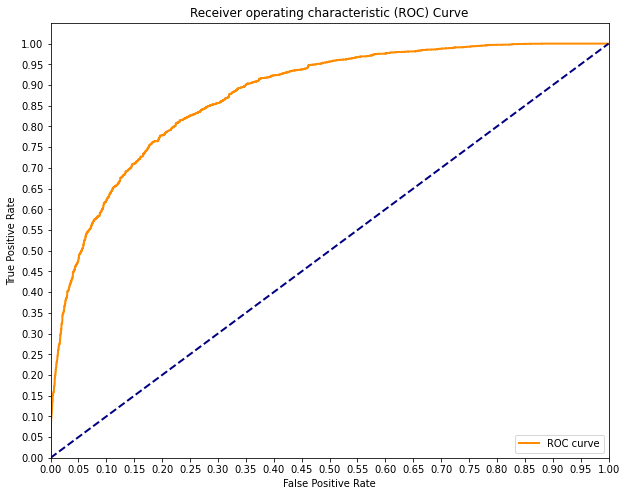

In [64]:
#Visualized ROC Curve
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [77]:
#Using only features with high correlation to target variable
X_hicorr = df.drop(columns = 'booking_status', axis = 1)
X_train_hicorr, X_test_hicorr, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 100)

#One-hot-encoded categorical features
ohe = OneHotEncoder(drop="first", sparse=False)
X_train_nominal_hicorr = X_train_hicorr[['market_segment_type', 'booking_month', 'repeated_guest']]
X_test_nominal_hicorr = X_test_hicorr[['market_segment_type', 'booking_month', 'repeated_guest']]
X_train_nominal_encoded_hicorr = pd.DataFrame(ohe.fit_transform(X_train_nominal_hicorr))
X_test_nominal_encoded_hicorr = pd.DataFrame(ohe.transform(X_test_nominal_hicorr))

#Scaled numerical features using StandardScaler
scaler = StandardScaler()
X_train_num_hicorr = X_train_hicorr[['lead_time', 'no_of_special_requests', 'avg_price_per_room', 'length_of_stay', 'total_guests']]
X_test_num_hicorr = X_test_hicorr[['lead_time', 'no_of_special_requests', 'avg_price_per_room', 'length_of_stay', 'total_guests']]
X_train_num_scaled_hicorr = pd.DataFrame(scaler.fit_transform(X_train_num_hicorr))
X_test_num_scaled_hicorr = pd.DataFrame(scaler.transform(X_test_num_hicorr))

#Concatenated encoded categorical and scaled numerical dataframes back into a full dataframe of encoded/scaled independent variables
X_train_hicorr = pd.concat([X_train_nominal_encoded_hicorr, X_train_num_scaled_hicorr], axis = 1)
X_test_hicorr = pd.concat([X_test_nominal_encoded_hicorr, X_test_num_scaled_hicorr], axis = 1)

#Used a Logistic Regression model and calculated AUC, recall, precision, accuracy, and F1
logreg_hicorr = LogisticRegression(fit_intercept = False, max_iter = 1000, C = 1e5, random_state = 100)
y_score_log_hicorr = logreg_hicorr.fit(X_train_hicorr, np.ravel(y_train)).decision_function(X_test_hicorr)
fpr_hicorr, tpr_hicorr, thresholds_hicorr = roc_curve(y_test, y_score_log_hicorr)
y_hat_train_hicorr = logreg_hicorr.predict(X_train_hicorr)
y_hat_test_hicorr = logreg_hicorr.predict(X_test_hicorr)

#Printed results
print(f"AUC: {auc(fpr_hicorr, tpr_hicorr)}")
print(f"Train Recall: {recall_score(y_train, y_hat_train_hicorr)}")
print(f"Test Recall: {recall_score(y_test, y_hat_test_hicorr)}")
print(f"Train Precision: {precision_score(y_train, y_hat_train_hicorr)}")
print(f"Test Precision: {precision_score(y_test, y_hat_test_hicorr)}")
print(f"Train Accuracy: {accuracy_score(y_train, y_hat_train_hicorr)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_hat_test_hicorr)}")
print(f"Train F1 Score: {f1_score(y_train, y_hat_train_hicorr)}")
print(f"Test F1 Score: {f1_score(y_test, y_hat_test_hicorr)}")

AUC: 0.8549587879880276
Train Recall: 0.624939584340261
Test Recall: 0.617434758467518
Train Precision: 0.7258947368421053
Test Precision: 0.7408394403730846
Train Accuracy: 0.8006386501616337
Test Accuracy: 0.8016924208977189
Train F1 Score: 0.671644698396208
Test F1 Score: 0.6735311932162326


AUC: 0.8549587879880276


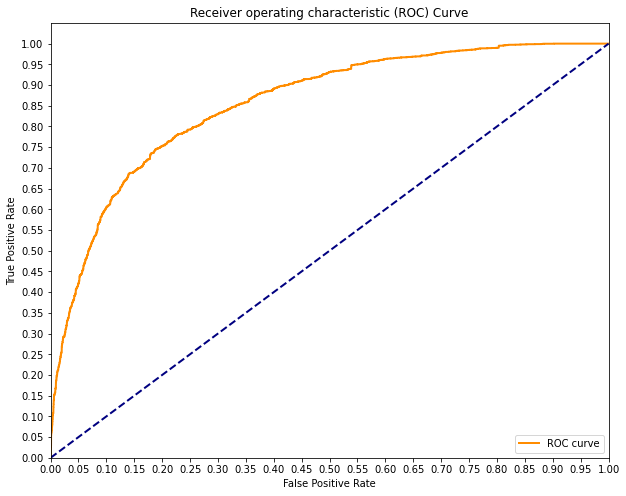

In [78]:
#Visualized ROC Curve
print('AUC: {}'.format(auc(fpr_hicorr, tpr_hicorr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr_hicorr, tpr_hicorr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [96]:
max_depths = list(range(1, 50))
train_results_depth = []
test_results_depth = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=100)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    # Add auc score to previous train results
    train_results_depth.append(roc_auc)
    y_pred = dt.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    # Add auc score to previous test results
    test_results_depth.append(roc_auc)

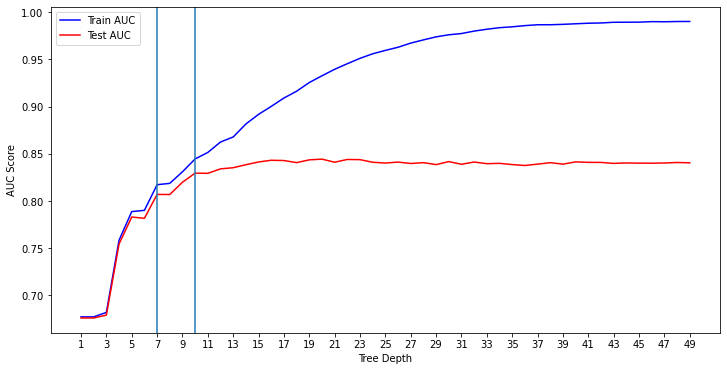

In [97]:
plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results_depth, 'b', label='Train AUC')
plt.plot(max_depths, test_results_depth, 'r', label='Test AUC')
plt.xticks(list(range(1, 50, 2)))
plt.axvline(x=10)
plt.axvline(x=7)
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.legend()
plt.show()

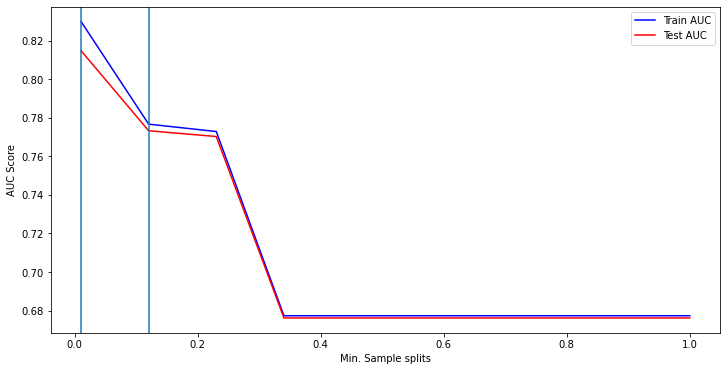

In [92]:
min_samples_splits = np.linspace(0.01, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=100)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    fpr, tpr, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.axvline(x=0.01)
plt.axvline(x=0.12)
plt.ylabel('AUC Score')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

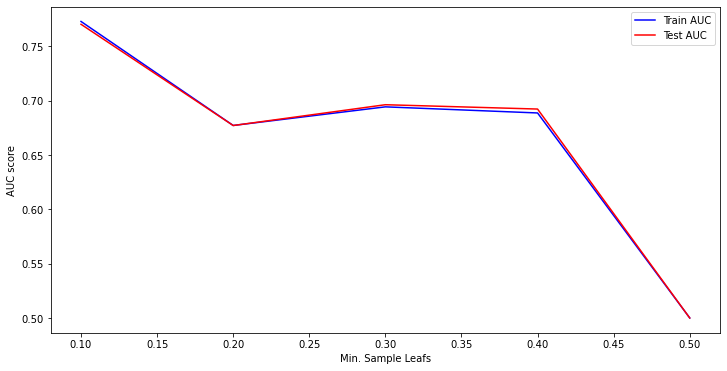

In [70]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=100)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

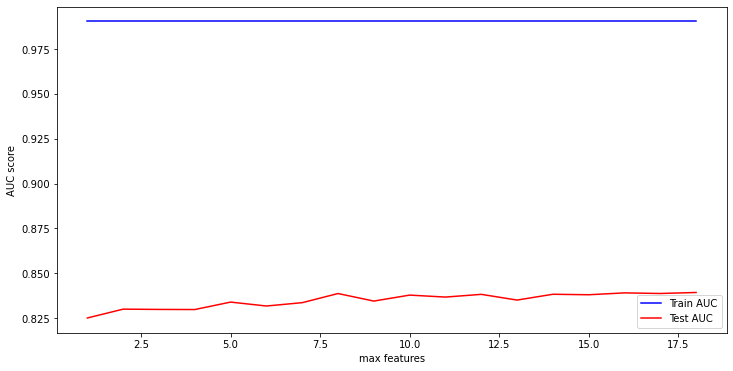

In [71]:
max_features = list(range(1, X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(criterion='entropy', max_features=max_feature, random_state=100)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()

In [72]:
print(max(test_results))

0.8392534103398157


In [73]:
dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=12,
                           max_depth=8,
                           min_samples_split=0.01,
                           min_samples_leaf=0.01, 
                           random_state=100)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7820321814183928

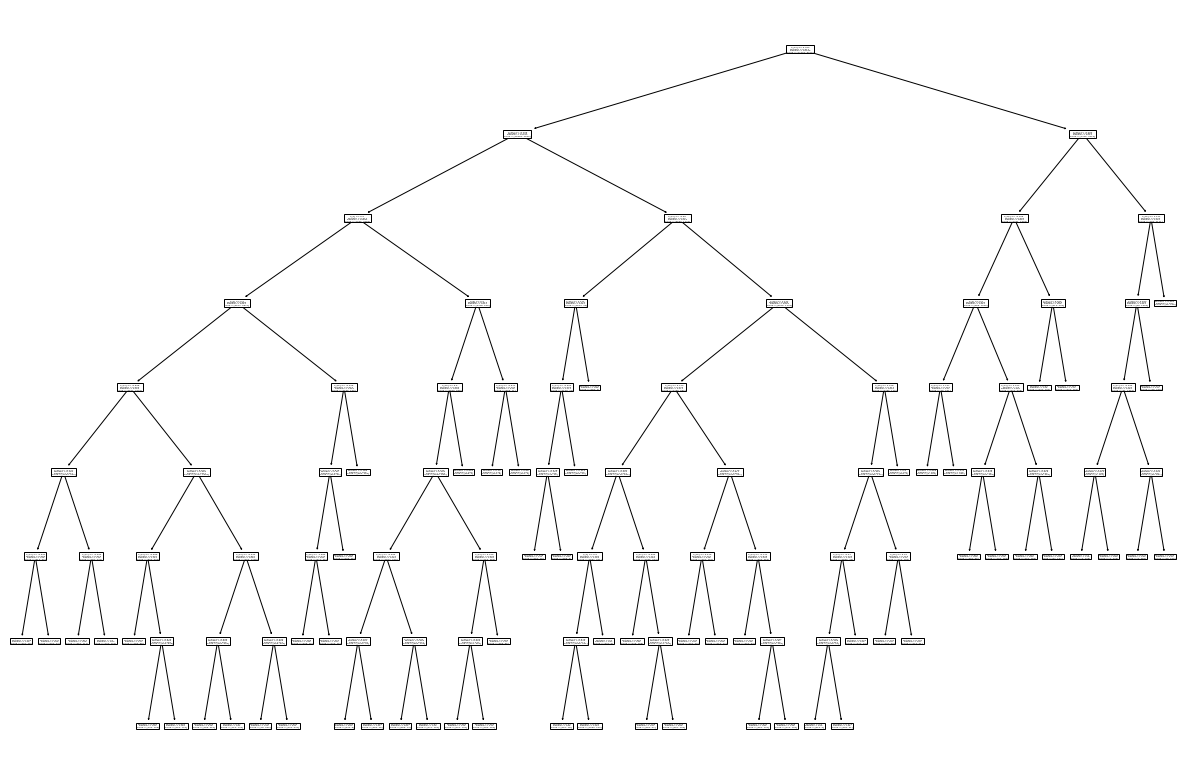

In [74]:
plt.figure(figsize= (21, 14))
plot_tree(dt)
plt.show()

In [75]:
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)
print(f"Train Recall: {recall_score(y_train, y_hat_train)}")
print(f"Test Recall: {recall_score(y_test, y_hat_test)}")
print(f"Train Precision: {precision_score(y_train, y_hat_train)}")
print(f"Test Precision: {precision_score(y_test, y_hat_test)}")
print(f"Train Accuracy: {accuracy_score(y_train, y_hat_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_hat_test)}")
print(f"Train F1 Score: {f1_score(y_train, y_hat_train)}")
print(f"Test F1 Score: {f1_score(y_test, y_hat_test)}")

Train Recall: 0.6575640405993234
Test Recall: 0.6476957245974458
Train Precision: 0.7888099724597768
Test Precision: 0.7932675960557634
Train Accuracy: 0.8308365528660412
Test Accuracy: 0.827354672553348
Train F1 Score: 0.7172322899505768
Test F1 Score: 0.7131285343114778
